In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt

import folium
from folium.plugins import HeatMap
from heatmap import corrplot

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import PowerTransformer, StandardScaler, OneHotEncoder, QuantileTransformer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

# Load and Examine the data 

In [3]:
df = pd.read_csv("kc_house_data.csv", parse_dates=['date'])
df.head(5)

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,2014-10-13,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,2014-12-09,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,2015-02-25,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,2014-12-09,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,2015-02-18,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   id             21613 non-null  int64         
 1   date           21613 non-null  datetime64[ns]
 2   price          21613 non-null  float64       
 3   bedrooms       21613 non-null  int64         
 4   bathrooms      21613 non-null  float64       
 5   sqft_living    21613 non-null  int64         
 6   sqft_lot       21613 non-null  int64         
 7   floors         21613 non-null  float64       
 8   waterfront     21613 non-null  int64         
 9   view           21613 non-null  int64         
 10  condition      21613 non-null  int64         
 11  grade          21613 non-null  int64         
 12  sqft_above     21613 non-null  int64         
 13  sqft_basement  21613 non-null  int64         
 14  yr_built       21613 non-null  int64         
 15  yr_renovated   2161

# Data Cleaning

Checking for missing values

In [3]:
def percent_missing(df):
    data = pd.DataFrame(df)
    df_cols = list(pd.DataFrame(data))
    dict_x = {}
    for i in range(0, len(df_cols)):
        dict_x.update({df_cols[i]: round(data[df_cols[i]].isnull().mean()*100,2)})
    
    return dict_x

missing = percent_missing(df)
df_miss = sorted(missing.items(), key=lambda x: x[1], reverse=True)
print('Percent of missing data')
df_miss[0:10]

Percent of missing data


[('id', 0.0),
 ('date', 0.0),
 ('price', 0.0),
 ('bedrooms', 0.0),
 ('bathrooms', 0.0),
 ('sqft_living', 0.0),
 ('sqft_lot', 0.0),
 ('floors', 0.0),
 ('waterfront', 0.0),
 ('view', 0.0)]

Great! There is no missing values

# EDA

Create new features

In [4]:
df['age'] = pd.DatetimeIndex(df['date']).year - df['yr_built']
df['renovated'] = df['yr_renovated'].apply(lambda x: 0 if x == 0 else 1)

df.drop(['zipcode','id','yr_built','yr_renovated','date'],axis = 1, inplace= True)

## Examine numeric variable

We will first examine the distribution of each numeric columns using histogram and use QQplot to examine the shape of the distribution

In [5]:
#seperate numerica features
num_cols = df.drop(columns = ['lat','long','renovated','waterfront'])

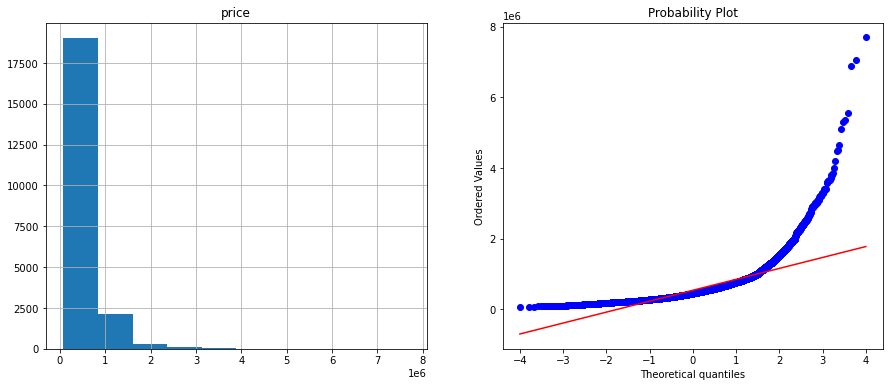

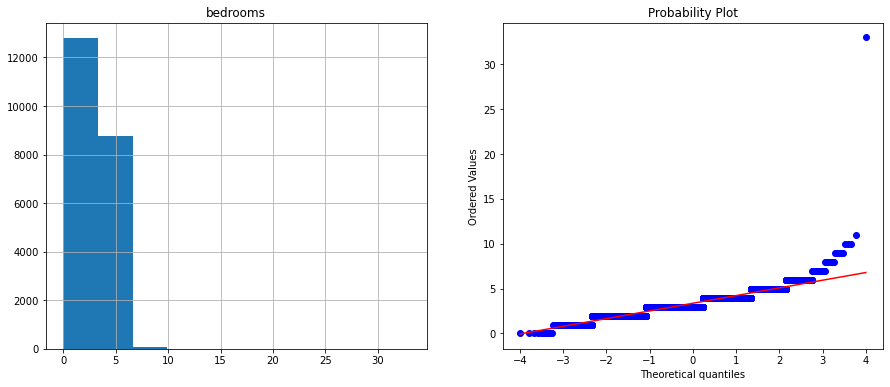

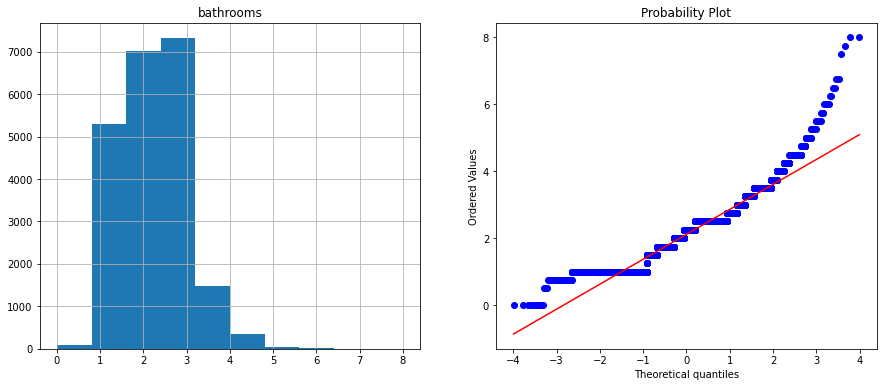

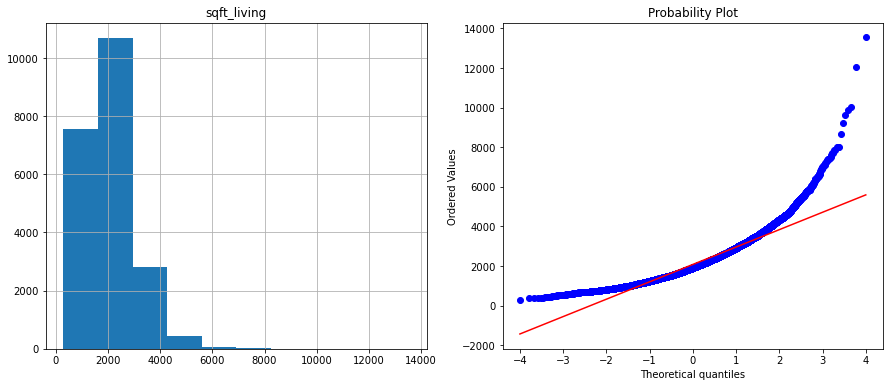

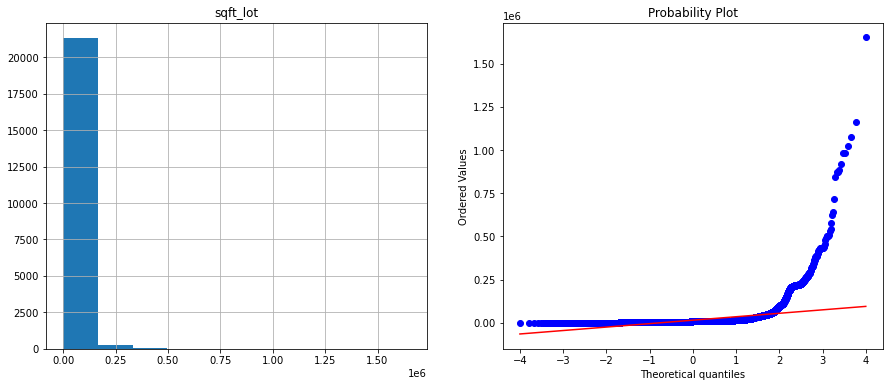

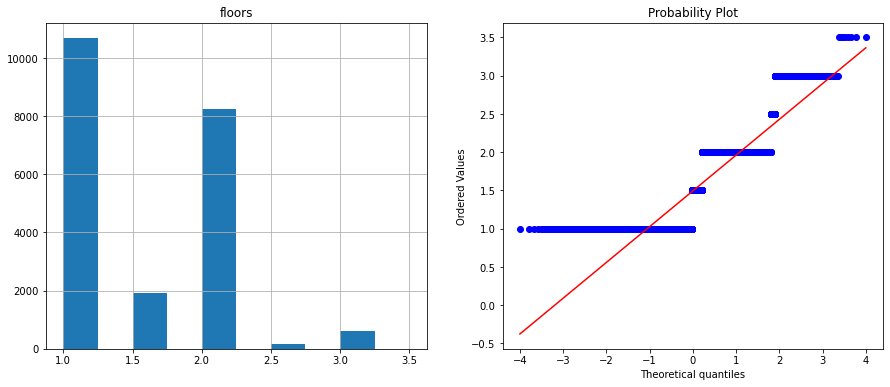

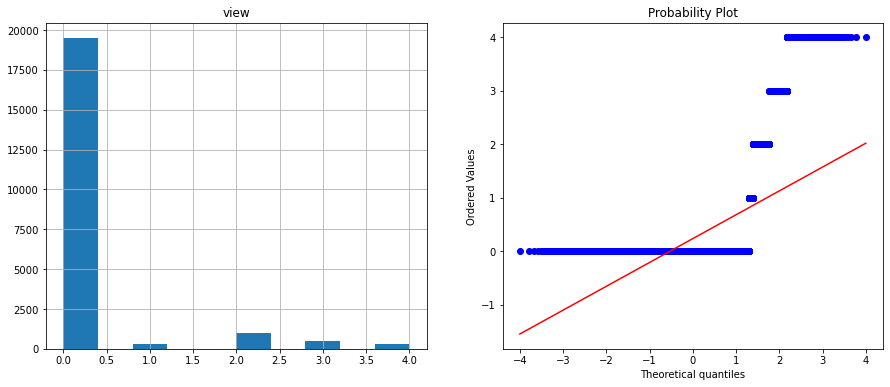

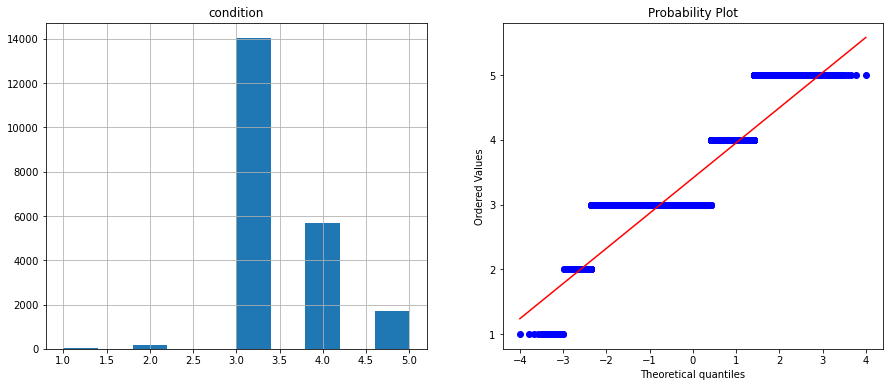

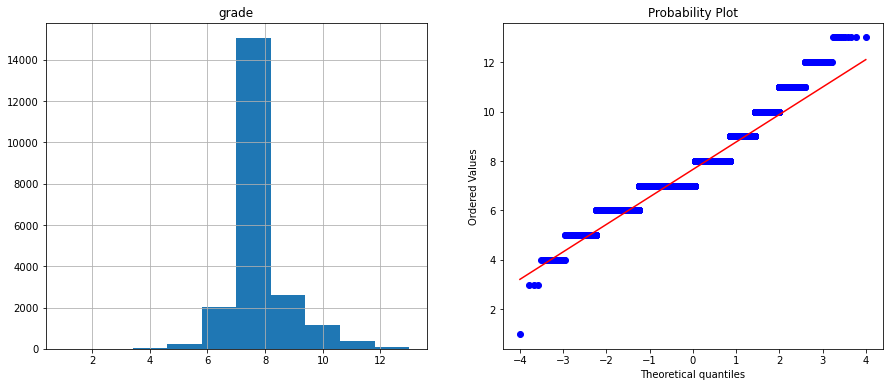

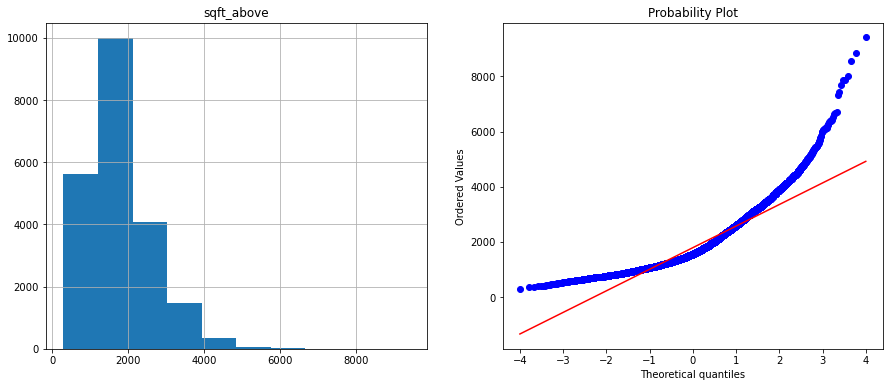

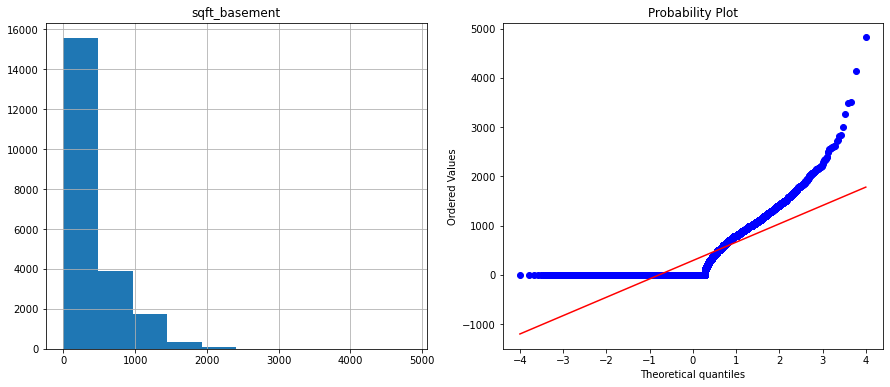

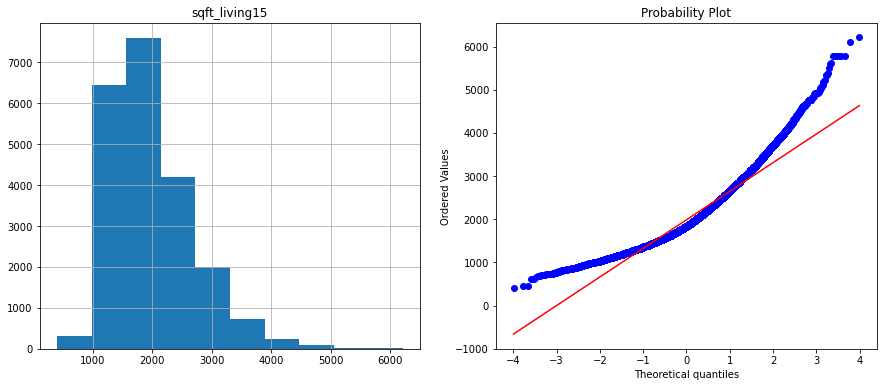

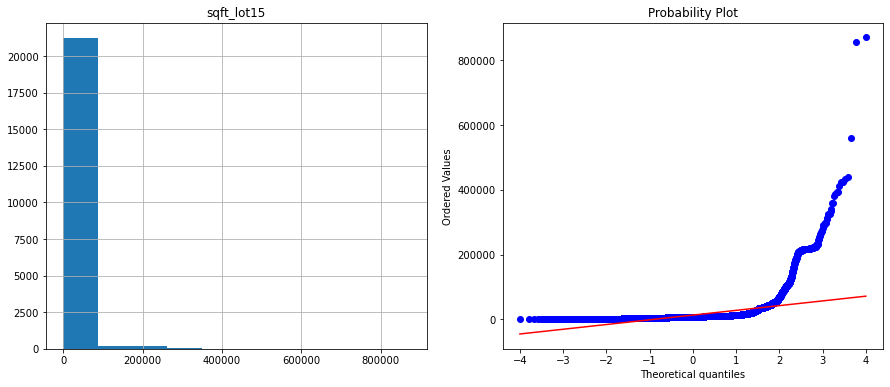

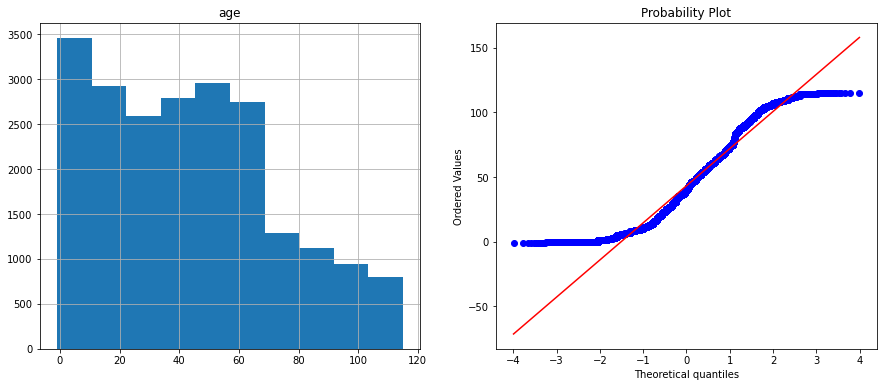

In [6]:
def diagnostic_plot(df, var):

    plt.figure(figsize=(15,6))
    plt.subplot(1,2,1)
    df[var].hist()
    plt.title(var)
    
    plt.subplot(1,2,2)
    stats.probplot(df[var],plot=plt)
    
    plt.show()
    
for var in num_cols.columns:
    diagnostic_plot(num_cols, var)

From the histogram we can see that: price, sqft_living, sqft_living15, sgft_iot, sgft_iot15, sqft_above, sqft_basement, bathroom age are all continuous variable while the rest are discrete.

Eventhough bathroom is a continuous variable within this data, I'm going to make it discrete by rounding the number for better visualization.

We can see from the above histogram that very few numeric features are normaly distributed. Features such as sqft_lot, bathrooms and price are highly skewed and sqft_basement has a very high number of 0 values. These will become a liability to a linear model as it decrease the reliability.

In [6]:
# rounding up the number of bathroom
df['bathrooms'] = np.round(df['bathrooms'])

## Examine correlation among variables 

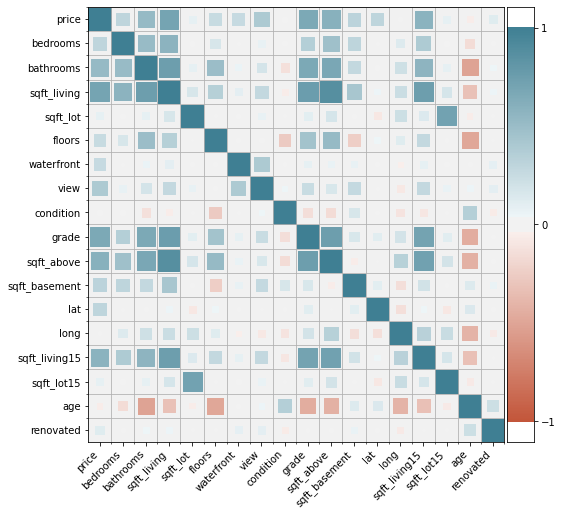

In [7]:
plt.figure(figsize=(8, 8))
corrplot(df.corr())

From this correlation map of the numeric features, we can see that:

- Features relating to sizes seems to influence the prices of the house the most, namely: "bedrooms", "badrooms", "sqft_living", "sqft_lot", "sqft_above", "sqft_living15", "grade". However, we need to keep in mind that these features are also correlated with one another as well.Therefore, some of these features need to be filtered out to avoid multicolinearity.

- Unexpectedly, age has very little to contritute to the price of the residence

## Further explore the relation ship between size features and price

In [7]:
def create_boxplot(colname,ax=None):
    return sns.boxplot(x=colname, y='price',data = df,ax=ax)

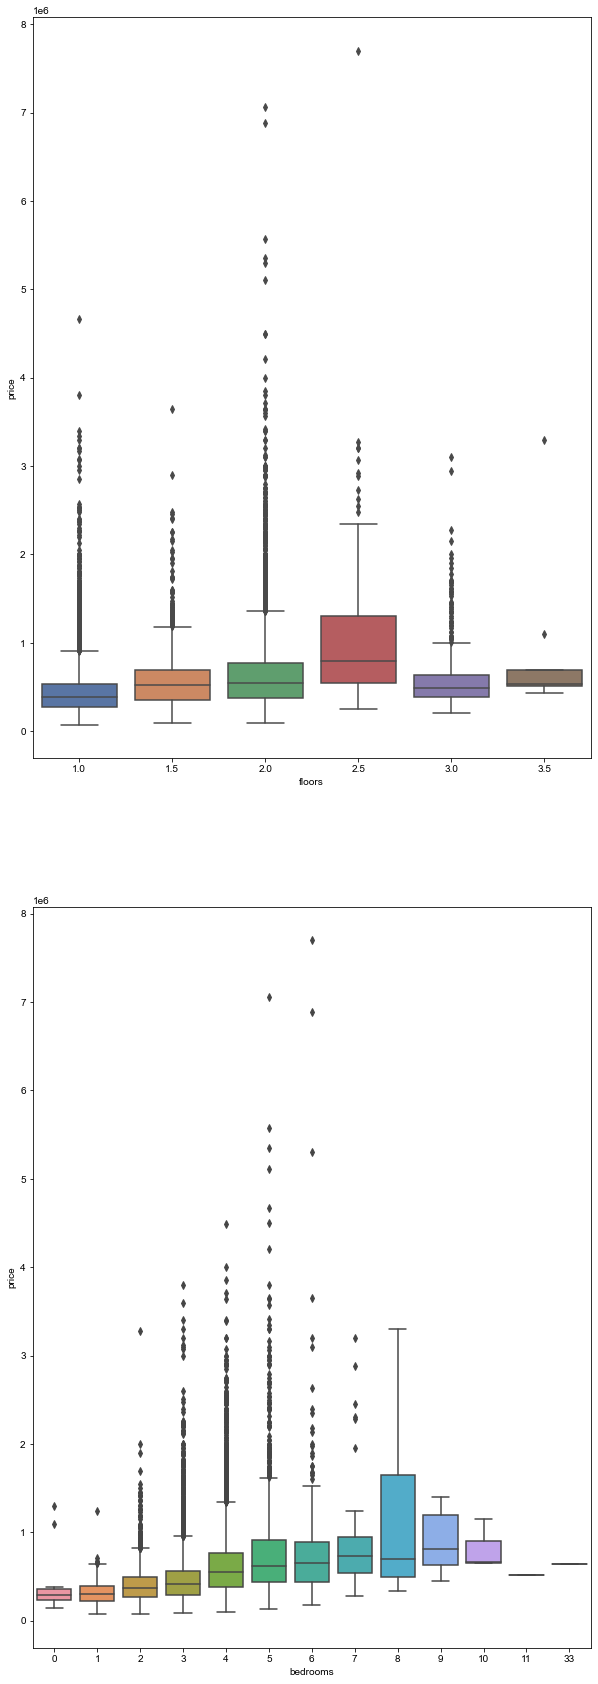

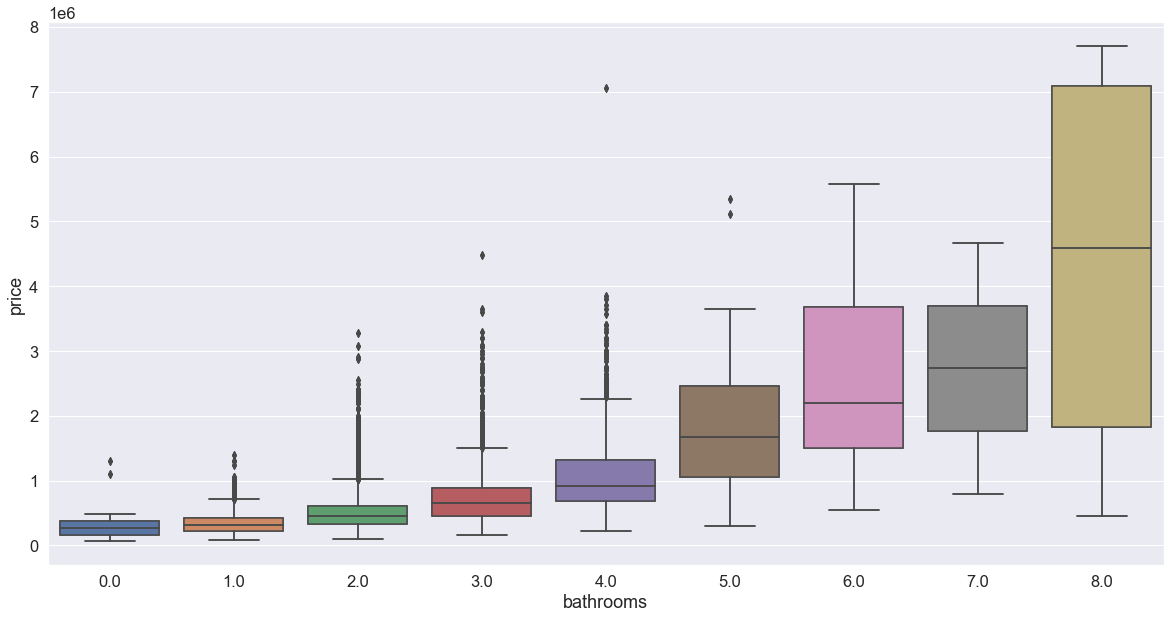

In [8]:
fig, axes = plt.subplots(2,1,figsize = (10,30))
sns.set(font_scale=1.5)
create_boxplot('floors',axes[0])
create_boxplot('bedrooms',axes[1])

fig, ax = plt.subplots(1,1, figsize = (20,10))
sns.boxplot(x='bathrooms', y='price',data = df, ax=ax)
create_boxplot('bathrooms',ax)

- There is a gradual increase in the median house price as the numer of floor increase. However, this trend ends at the houses with 3 storeys. 
- The simmilar trend could be seen in the number of bedroom of a houses. The median price of the houses increase as the number of bathroom increase.
- This isn't the case with the number of bathrooms though as there is a steady trend and correlation between number of bathroom and the median house price. One thing to noice is that house prices with 8 bathrooms have a greater variance compares to other houses.

## Visualizing price by categorical variables 

Seeing how price differs in each variable grouping using viloin plot

In [9]:
def creat_violinplot(colname, ax=None):
    sns.violinplot(x=df[colname],y=df['price'],ax=ax)

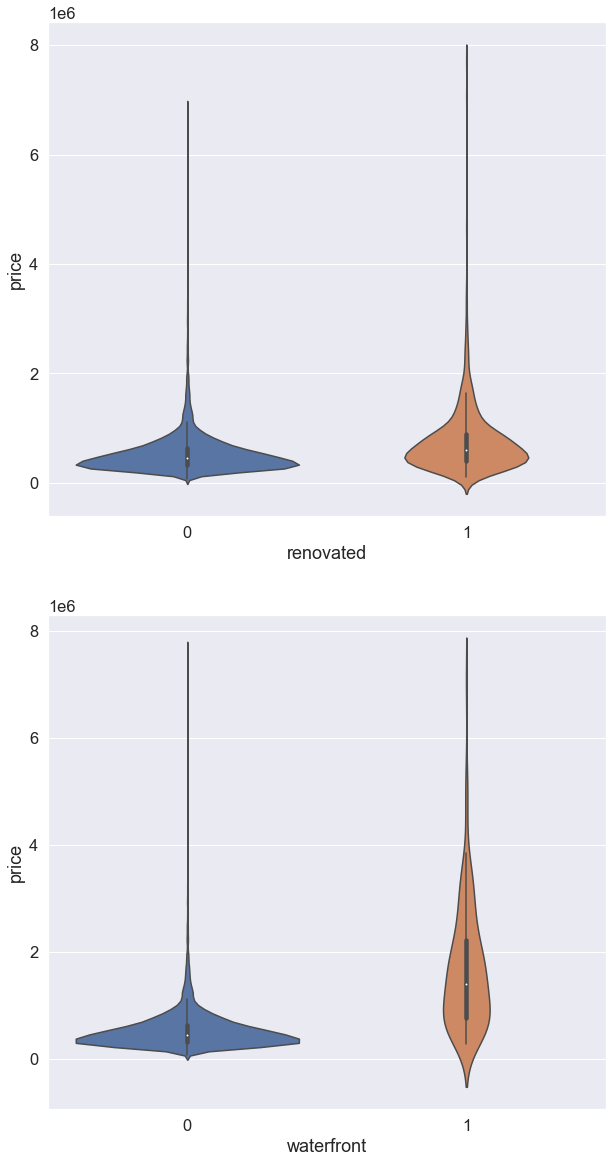

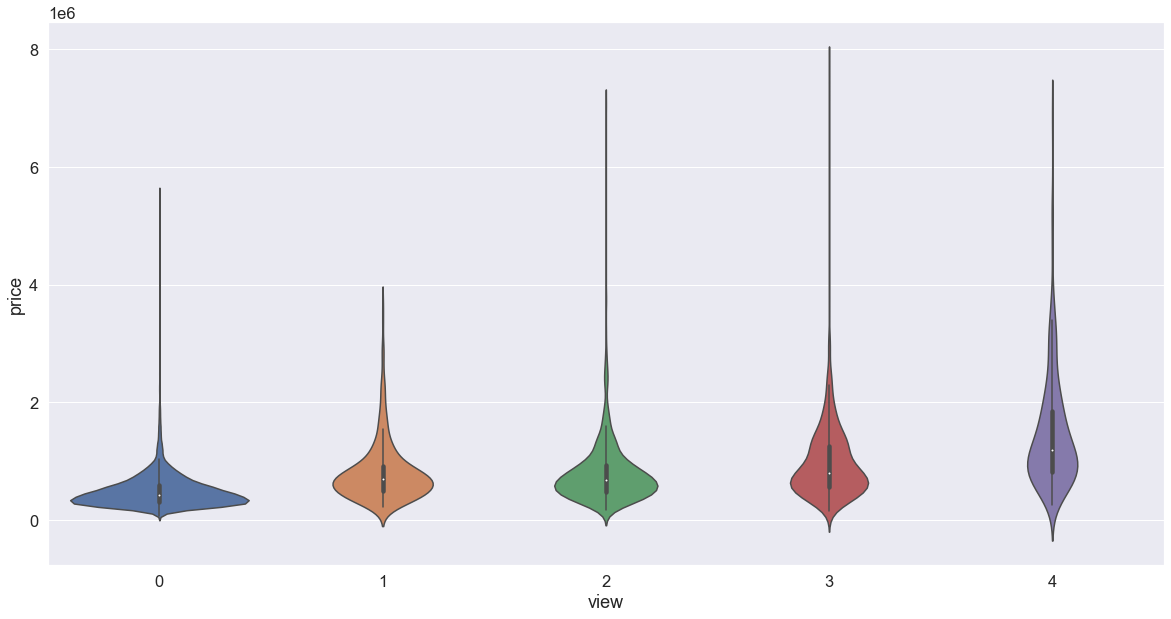

In [11]:
fig, axes = plt.subplots(2,1,figsize=(10,20))
sns.set(font_scale=1.5)
creat_violinplot('renovated',axes[0])
creat_violinplot('waterfront',axes[1])

fig, ax = plt.subplots(1,1,figsize=(20,10))
creat_violinplot('view',ax)

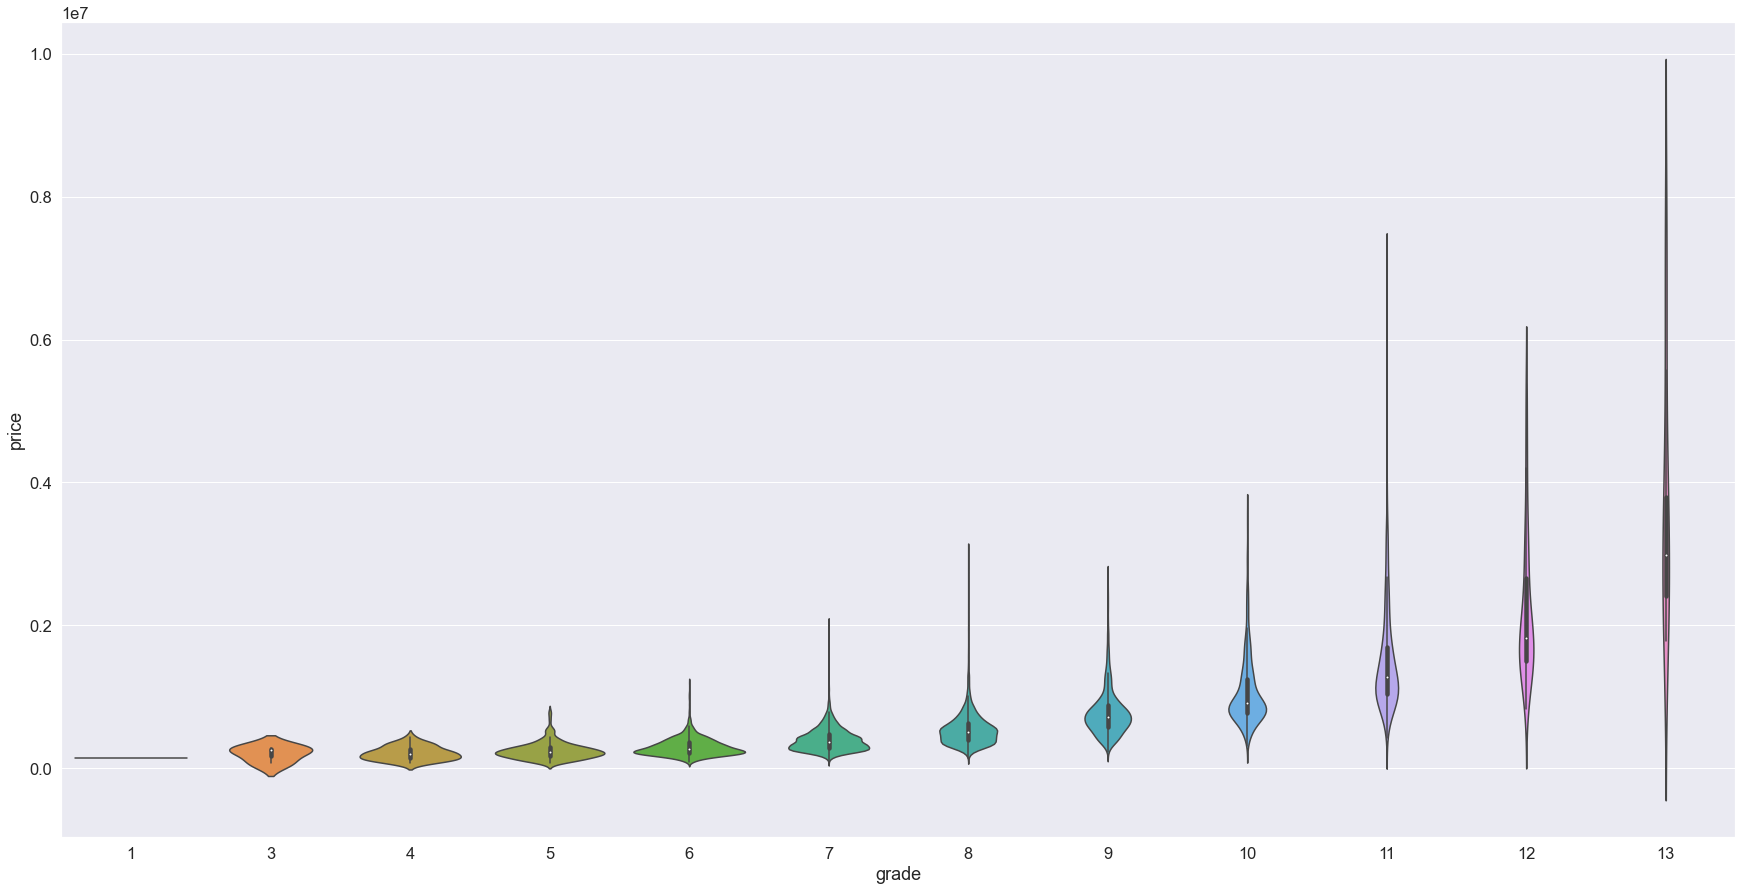

In [12]:
plt.figure(figsize=(30,15))
creat_violinplot('grade')
sns.set(font_scale=3)

Each of these features has a visible effect on price. View seems to be the features where the effect on price is less distinctiive

## Visualizing price by location

Intuitively, it makes sense that the location of the house largely influence the price as well, let's visualize the distribution of house prices on map using longtitude and latitude as metrics

In [90]:
maxpr=df.loc[df['price'].idxmax()]

# define a function to draw a basemap easily
def generateBaseMap(default_location=[47.5112, -122.257], default_zoom_start=9.4):
    base_map = folium.Map(location=default_location, control_scale=True, zoom_start=default_zoom_start)
    return base_map

df_copy = df.copy()
# select a zipcode for the heatmap
#set(df['zipcode'])
#df_copy = df[df['zipcode']==98001].copy()
df_copy['count'] = 1
basemap = generateBaseMap()
# add carton position map
folium.TileLayer('cartodbpositron').add_to(basemap)
s=folium.FeatureGroup(name='icon').add_to(basemap)
# add a marker for the house which has the highest price
folium.Marker([maxpr['lat'], maxpr['long']],popup='Highest Price: $'+str(format(maxpr['price'],'.0f')),
              icon=folium.Icon(color='green')).add_to(s)
# add heatmap
HeatMap(data=df_copy[['lat','long','count']].groupby(['lat','long']).sum().reset_index().values.tolist(),
        radius=8,max_zoom=13,name='Heat Map').add_to(basemap)
folium.LayerControl(collapsed=False).add_to(basemap)
basemap

### Discretizing geographical features

In [7]:
df['ver_loc'] = pd.cut(df['lat'],3,labels=['South','Mid','North'])
df['horz_loc'] = pd.cut(df['long'],3,labels=['West','Mid','East'])

df.drop(['lat','long'],axis=1,inplace=True)

---

# Spliting data 

In [8]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=['price']), df.price)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(16209, 17) (16209,)
(5404, 17) (5404,)


# Preprocessing data

In [9]:
# Separate numerical features
num_feats = num_cols.drop(columns=['price']).columns

# Transformer to normalize and fit numeric data to gaussian distribution
num_processor = Pipeline([('Qtf',QuantileTransformer(output_distribution='normal')),
                           ('scaler',StandardScaler())])

# Create column transformer to process categorical and numerical variable separatedly
processor = ColumnTransformer([('encoder', OneHotEncoder(drop='first',handle_unknown='error'), ['ver_loc','horz_loc']),
                              ('num_processor', num_processor, num_feats)], remainder='passthrough')

Examining target variable distribution

In [10]:
processed_X_train = processor.fit_transform(X_train)
processed_X_test = processor.transform(X_test)

---

# Modeling

## Model Selection 

In [11]:
from sklearn.linear_model import Ridge, Lasso
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR

In [12]:
for model in [Ridge(), Lasso(), GradientBoostingRegressor(), 
              RandomForestRegressor(), KNeighborsRegressor(), SVR()]:
    cv_score = cross_val_score(model, processed_X_train, y_train, scoring='neg_mean_squared_error' ,cv=5)
    score = np.sqrt(-cv_score).mean()
    print("Accuracy score for %s: %.3f"%(model, score.mean()))

Accuracy score for Ridge(): 230485.116
Accuracy score for Lasso(): 230498.066
Accuracy score for GradientBoostingRegressor(): 165014.498
Accuracy score for RandomForestRegressor(): 160985.982
Accuracy score for KNeighborsRegressor(): 189988.360
Accuracy score for SVR(): 387941.738


It seems that Gradient Boosting Regressor and Ramdom Forest Regressor yield the best results

## Fine Tune the system 

### Gradient Boosting Regressor 

In [24]:
gbr_param_grid = [{'loss':['ls', 'lad'],'learning_rate':[0.1,0.01],'n_estimators':[50, 100]}]

gbr_tune = GridSearchCV(GradientBoostingRegressor(), gbr_param_grid, 
                        cv=5,scoring='neg_mean_squared_error',
                        return_train_score=True,n_jobs=-1, verbose=1)

gbr_tune.fit(processed_X_train,y_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:   12.0s finished


GridSearchCV(cv=5, estimator=GradientBoostingRegressor(), n_jobs=-1,
             param_grid=[{'learning_rate': [0.1, 0.01], 'loss': ['ls', 'lad'],
                          'n_estimators': [50, 100]}],
             return_train_score=True, scoring='neg_mean_squared_error',
             verbose=1)

In [25]:
# Viewing the best hyperparameters
gbr_tune.best_params_

{'learning_rate': 0.1, 'loss': 'ls', 'n_estimators': 100}

In [38]:
# Getting the best estimator and train the model with it 
gbr_model = gbr_tune.best_estimator_
gbr_model.fit(processed_X_train,y_train)

GradientBoostingRegressor()

***

### Random Forest Regressor 

For Random forest, we can use the original data to train as it does not require the feature to be scaled 

In [28]:
rf_param_grid = [{'n_estimators': [80,100,120], 'max_features':[10,14,17], 'bootstrap':[False, True]}]

forest_tune = GridSearchCV(RandomForestRegressor(), rf_param_grid, cv=5,
                           scoring='neg_mean_squared_error',
                           return_train_score=True, n_jobs=-1, verbose=1)

forest_tune.fit(processed_X_train, y_train)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   59.4s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:  2.2min finished


GridSearchCV(cv=5, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid=[{'bootstrap': [False, True],
                          'max_features': [10, 14, 17],
                          'n_estimators': [80, 100, 120]}],
             return_train_score=True, scoring='neg_mean_squared_error',
             verbose=1)

In [39]:
# Viewing the best hyperparameters
forest_tune.best_params_

{'bootstrap': False, 'max_features': 10, 'n_estimators': 120}

In [40]:
# Getting the best estimator and train the model with it 
rf_model = forest_tune.best_estimator_
rf_model.fit(processed_X_train,y_train)

RandomForestRegressor(bootstrap=False, max_features=10, n_estimators=120)

---

# Model evaluation 

In [46]:
def rmse_of_model(model):
    y_predicted = model.predict(processed_X_test)
    mse = mean_squared_error(y_test,y_predicted)
    return np.sqrt(mse)

In [49]:
# Get root mean square error of both model on test set
print("RMSE of Gradient Boosting Regressor: %.3f"%rmse_of_model(gbr_model))
print("RMSE of Random Forest Regressor: %.3f"%rmse_of_model(rf_model))

RMSE of Gradient Boosting Regressor: 165502.701
RMSE of Random Forest Regressor: 164263.214
